<a href="https://colab.research.google.com/github/furio1999/Natural-Language-Processing/blob/main/02a_A_real_world_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Copyright 2021 Sapienza NLP research group (http://nlp.uniroma1.it/)**

Authors: Edoardo Barba, Michele Bevilacqua, Cesare Campagnano, Simone Conia, ‪Pere-Lluís Huguet Cabot‬, Luigi Procopio, Roberto Navigli

All the material is made available under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 License (international): https://creativecommons.org/licenses/by-nc-sa/4.0/.

# Introduction

Hello and welcome to our Practical Deep Learning for NLP 101 course! In this Chapter, we'll get our hands dirty with a more realistic problem. We all love the XOR function, but why don't we review videogames instead?

Let's read the reviews that buyers wrote for some videogames and see if we can guess their opinions!

# Preparing the Environment

Differently from the previous Chapter, this time we will be working with a real-world dataset. First thing first, we'll need to retrieve it.

In [ ]:
# sample_data: we don't need this folder
! rm -rf sample_data

# let's create a new folder and download the dataset. We'll also need to unzip it
! mkdir data
! wget -O data/amazon-reviews.tsv.gz https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz
! gzip -d data/amazon-reviews.tsv.gz

--2021-03-08 13:06:38--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.94.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.94.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 475199894 (453M) [application/x-gzip]
Saving to: ‘data/amazon-reviews.tsv.gz’

data/amazon-reviews 100%[===================>] 453.19M  63.4MB/s    in 6.9s    

2021-03-08 13:06:45 (65.6 MB/s) - ‘data/amazon-reviews.tsv.gz’ saved [475199894/475199894]



**Reminder:** this is bash! Learning to properly alternate between python, bash and other "languages" is something vital in data science. Surely python is nice, but isn't it overkill to use it to download a file or create a folder?

Let's import a few packages that we'll need through the notebook!

In [ ]:
# general
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from tqdm.notebook import tqdm
from typing import *

In [ ]:
# torch
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

# Amazon Reviews

The dataset we are going to use is [Amazon Reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html); it is a well-known dataset in the ML community that is frequently used in multiple settings.

As it's really gigantic, it is divided in different sub-datasets based on the Amazon categories we all know. Today, we'll use the VideoGames sub-dataset.

## Dataset

So, first of all, let's check its format.

In [ ]:
! head -5 data/amazon-reviews.tsv

marketplace	customer_id	review_id	product_id	product_parent	product_title	product_category	star_rating	helpful_votes	total_votes	vine	verified_purchase	review_headline	review_body	review_date
US	12039526	RTIS3L2M1F5SM	B001CXYMFS	737716809	Thrustmaster T-Flight Hotas X Flight Stick	Video Games	5	0	0	N	Y	an amazing joystick. I especially love that you can twist ...	Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.	2015-08-31
US	9636577	R1ZV7R40OLHKD	B00M920ND6	569686175	Tonsee 6 buttons Wireless Optical Silent Gaming Mouse For PC Laptop Gamer Red	Video Games	5	0	0	N	Y	Definitely a silent mouse... Not a single click was heard	Loved it,  I didn't even realise it was a gaming mouse,  I typed in &#34;silent mouse&#34; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might ju

This is a TSV file. TSV is a format you'll soon get very acquainted with; while now it may appear pretty much unreadable, you'll be preying to encounter it when searching for datasets (way worse and unfathomable formats exist).

Indeed, it's extremely easy to parse. Each line represents a data sample and information for this sample are reported into tab-separated columns. Often (i.e. when you are lucky as in this case), the first line is used to report what each column stands for.

Here, we are interested in **reviews** (column 14) and their corresponding **number of stars** (column 8); thus, columns 8 and 14 have all the information we need.

Let's discard all the other columns and make the file more readable; we will stick with bash so that you get familiar with its usage (why don't you try to do the same with python? Meanwhile, if you don't know the meaning of *tail*, *cut* and *head*, check them out).



In [ ]:
! tail +2 data/amazon-reviews.tsv | cut -f8,14 > data/dataset.raw.tsv 
! head -5 data/dataset.raw.tsv

5	Used this for Elite Dangerous on my mac, an amazing joystick. I especially love that you can twist the stick for different movement bindings as well as move it in the normal way.
5	Loved it,  I didn't even realise it was a gaming mouse,  I typed in &#34;silent mouse&#34; and selected this one. It is perfect and looks pretty cool as well. Now my boyfriend's gaming is wonderfully comfortably silent :) . Think I might just get one for myself.
1	poor quality work and not as it is advertised.
3	nice, but tend to slip away from stick in intense (hard pressed) gaming sessions.
4	Great amiibo, great for collecting. Quality material to be desired, since its not perfect.


Finally, it's something humans can read! We can now formulate the goal of this Chapter more explicitly: given a review, we want to learn a function $f$ that predicts how many stars the reviewer originally gave.

Thus, if we receive *poor quality work and not as it is advertised*, we want to predict $1$. Conversely, *Loved it,  I didn't even realise it was a gaming mouse...* is clearly a $5$!

**!!! TIP !!!**

Every time you get your hands on new data, before doing anything else, it's crucial that you investigate them a bit. You can extract useful insights from them that might help you later on.

In this case, there's a natural question that arises. How are the stars distributed? Do we have as many $1$-s as $5$-s? Are $5$-s the most frequent scores? Or are they $3$-s? Let's check it out! 

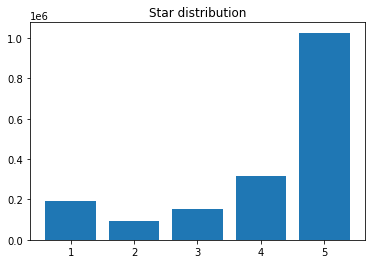

In [ ]:
#@title

def visualize_n_stars(dataset: str, title: str):
    
    star_counter = Counter()

    with open(dataset) as f:
        for line in f:
            star = int(line.strip().split('\t')[0])
            star_counter[star] += 1

    stars = sorted(star_counter)
    values = [star_counter[star] for star in stars]

    plt.bar(stars, values)
    plt.title(title)
    plt.show()

visualize_n_stars('data/dataset.raw.tsv', 'Star distribution')

So, $5$-s are by far the most frequent scores!

**Exercise.** Compute statistics for the words in the reviews and see which words are most frequent.

## Simplification

As a matter of fact, this task is **extremely complex**, especially as we are restrained with the few tools presented so far. There are $2$ major obstacles:
* This task is way more complex than a simple XOR function. Even if we did this task manually ourselves, we still woudn't achieve 100% accuracy!
* How do we deal with text?

In order to deal with both, we will simplify the task. In particular, starting from the official dataset, let's create a new one that is easier.

How? Simple! Let's define the following set of markers:

In [ ]:
positive_markers = {'fantastic', 'amazing', 'excellent', 'very good'}
neutral_markers = {'adequate', 'fine but', 'good but', 'ok but'}
negative_markers = {'returning', 'sucks', 'waste'}

We will discard all positive reviews ($4$ and $5$) that do not contain the above positive markers; we'll repeat the same for neutral and negative reviews.

**More complex:** try to add some confusing markers to make the dataset harder.

In [ ]:
markers = positive_markers | neutral_markers | negative_markers
assert len(markers) == len(positive_markers) + len(neutral_markers) + len(negative_markers)

star2markers = {
    1: negative_markers,
    2: negative_markers,
    3: neutral_markers,
    4: positive_markers,
    5: positive_markers
}

progress_bar = tqdm()
star_writes = Counter()

with open('data/dataset.raw.tsv') as fi, open('data/dataset.tsv', 'w') as fo:

    for i, line in enumerate(fi):

        try:

            star, review = line.strip().lower().split('\t')
            star = int(star)

            assert len(review) > 20 and len(review) < 100
            assert any(m in review for m in star2markers[star])

            star_writes[star] += 1
            fo.write(f'{star}\t{review}\n')

        except:
            pass

        progress_bar.update()
        if i % 1_000 == 0:
            # ** uses the dictionary as individual parameters with the key name and their value
            progress_bar.set_postfix(**{str(k): v for k, v in star_writes.items()})

progress_bar.close()

We have now generated a dataset that:
* is way smaller than the original one
* has **clear patterns** that denote the expected number of stars

Finally, let's split it into $2$ parts:
* *train*, a large chunk of data that we'll use to train our NN
* *test*, a smaller chunk that we'll use to report the results

We'll talk more about this splitting strategy in the next Chapter. For the moment, suffice it to say that we can use *test* as a proxy of the generalization capability of our network since our NN is not trained upon its data.

In [ ]:
! head -1000 data/dataset.tsv > data/test.tsv
! tail +1001 data/dataset.tsv > data/train.tsv
! wc -l data/test.tsv data/train.tsv

   1000 data/test.tsv
  17315 data/train.tsv
  18315 total


Always check the stats!

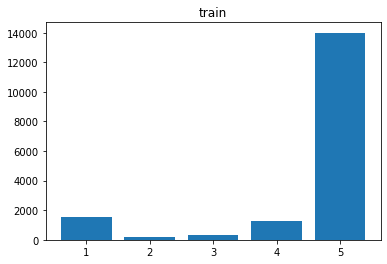

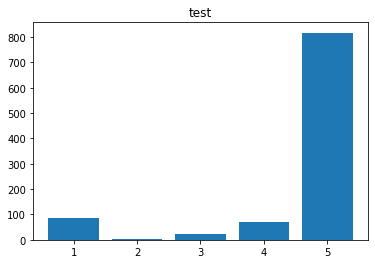

In [ ]:
#@title

visualize_n_stars('data/train.tsv', 'train')
visualize_n_stars('data/test.tsv', 'test')

# Feature Extraction

So, how do we deal with text? As we have seen in the previous Chapter, a neural network is composed of matrices and its input and output are expected to be matrices as well.

Thus, we need to somehow convert reviews into matrices. This process is called **feature extraction**. Let's start with something simple to get a general idea.

Imagine we have two reviews:
* *this game is a waste of money*, whose rating was a $1$
* *truly amazing game!*, whose rating was a $5$

Isn't it true that, if a review contains the word *waste*, then it's a $1$? And, similarly, if it contains the word *amazing*, then it's a $5$? Yes! Indeed, *amazing* and *waste* are effective markers that can be used to detect the orientation of a given review. This is exactly what a feature is!

Let's exploit this to define a function $\phi: r \rightarrow \mathbb{R}^{2}$, that is a function that takes as input a review $r$ and emits a 2d vector $x$, constructed as follows:
* $x_0 = 1$ if *amazing* is present in $r$; else $x_0 = 0$
* $x_1 = 1$ if *waste* is present in $r$; else $x_1 = 0$

Thus:

\\[ \phi(\text{this game is a waste of money}) = \begin{bmatrix} 0.0, 1.0 \end{bmatrix} \\]
\\[ \phi(\text{truly amazing game}) = \begin{bmatrix} 1.0, 0.0 \end{bmatrix} \\]

Leveraging $\phi$, approximating our target function $f$ with a NN is now something we can do!

**!!! NOTE !!!**

Of course, there are obvious limitations to this approach; just imagine *I was hoping for an amazing game, instead this is terrible!*, which is clearly a $1$. 
Yet, regardless of its simplicity, the crucial point of this section is that you understand function $\phi$ and its role in NN-s; once you grasp it, scaling to more heterogenous and realistic scenarios will be a matter of swapping the function $\phi$. Bear with us!


We have seen how we can build a function $\phi$ from a list of markers; however, a further question naturally arises: what markers should we use?

As it turns out, we know all the possible markers we are interested in! Indeed, with this very objective in mind, we built the simplified dataset by specifying a list of markers that had to be present in positive, neutral and negative reviews!

Let's implement our real function $\phi$.


In [ ]:
marker2idx = {marker: idx for idx, marker in enumerate(markers)}

In [ ]:
def review2vector(review: str):
    vector = torch.zeros(len(marker2idx), dtype=torch.float)
    for marker, idx in marker2idx.items():
        if marker in review:
            vector[idx] = 1
    return vector

In [ ]:
# 4 star review
print(review2vector('very good product. excellent quality'))

# 1 star review
print(review2vector('It echoes so badly with my voice. Don\'t waste your time. I\'m heavily considering returning it.'))

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


Thus, we can now convert any review $r$ into a vector $v$ that can be fed to a neural network!

# Training Procedure

Now that we have both data and $\phi$, let's get back to neural networks. We'll first zoom on a couple of details we glimpsed over in the previous chapter and then recast our problem in $3$ different ways, each using a different type of loss (and slightly different architecture).

## More on PyTorch: Datasets and DataLoaders

In the previous Chapter, we mentioned how neural networks' training is commonly performed over batches, rather than samples; this is motivated by both mathematical and efficiency reasons. However, we wanted to keep things simple and did not present how this is actually done in PyTorch. As it turns out, it's actually very easy.

Virtually the entirety of PyTorch data handling builds upon $2$ concepts:
* *Dataset*
* *DataLoader*

A *Dataset* is a simple abstraction that represents a collection of samples which can be emitted in tensor form. In its simplest version (*map-style*), it's a class that implements the \_\_getitem\_\_() and \_\_len\_\_() methods; in our case; a Dataset is something we can access with the $dataset[idx]$ syntax, which will yield the $idx$-th review, along with the associated number of stars, both of them in tensor form.

Let's implement the PyTorch Dataset for our task.


In [ ]:
class ReviewDataset(Dataset):

    def __init__(self, dataset_path: str, feature_extraction_function: Callable[[str], torch.tensor]):
        # standard constructor
        self.dataset_path = dataset_path
        self.feature_extraction_function = feature_extraction_function
        # call to init the data
        self._init_data()

    def _init_data(self):
        # iterate on the given file and build samples
        self.samples = []
        with open(self.dataset_path) as f:
            for line in f:
                star, review = line.strip().split('\t')
                # use the feature extraction function to convert reviews into tensors
                self.samples.append((self.feature_extraction_function(review), torch.tensor(int(star))))
                
    def __len__(self):
        # returns the number of samples in our dataset
      return len(self.samples)

    def __getitem__(self, idx):
        # returns the idx-th sample
        return self.samples[idx]

Ok, now that we defined the class, we can actually read the *train* and *test* dataset.

In [ ]:
train_dataset = ReviewDataset('data/train.tsv', review2vector)
test_dataset = ReviewDataset('data/test.tsv', review2vector)

# what's inside a sample?
train_dataset[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), tensor(5))

On the other hand, a *DataLoader* is the component that bridges the gap between samples and batches. We will see that, as the problems and the approximating $f$-s we consider become more convoluted, a *DataLoader* is a powerful component that takes care of quite a few nuisances.

It is quite easy to build DataLoader-s from Dataset-s. We'll use $32$ as the batch size, meaning the batches will be composed of $32$ samples.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

for batch in train_dataloader:
    # the type of batch is: Tuple[torch.Tensor, torch.Tensor]
    batch_x, batch_y = batch
    print(f'# batch len: {len(batch_x)}')
    print(f'# batch x: \n{batch_x}')
    print(f'# batch y: \n{batch_y}')
    break

# batch len: 32
# batch x: 
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],


As we can see, while ReviewDataset reads a list of pairs $(x, y)$, with $x$ being the review and $y$ the score, we can use the dataloader to seamlessly batch them.

## 3 Losses

Up to this point, we have only shown the MSE loss. This loss is perfect in regression problems (i.e. $f(x)=2x$). However, when dealing with **classification tasks**, such as determining whether a given image contains a dog, a cat or a bird, MSE is not appropriate for a number of mathematical reasons we won't delve in; rather, losses such as the cross-entropy loss are used.

Our star-prediction problem can be treated both as a regression and classification task; indeed, we can frame it either as the prediction of a *float* in the $[1, 5]$ range, whose output we round at postprocessing, or as the selection of the best class $c \in \{1, 2, 3, 4, 5\}$ for the considered review.

 We'll first consider the former configuration, as we are already familiar with it and its MSE loss. Then, we'll consider $2$ different classification variants.

Let's first define a training loop function so that we can avoid to re-implementing it every time. We will also pass an *adapt* hook that takes as input the batched $x$ and $y$ and adapts to them the variant being considered; it'll become clear later the purpose of this function.

In [ ]:
def training_loop(model: nn.Module, optimizer: torch.optim.Optimizer,  adapt: Callable[[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]], epochs: int = 5):

    for epoch in range(epochs):

        progress_bar = tqdm()

        # batches of the training set
        for x, y in train_dataloader:

            x, y = adapt(x, y)

            optimizer.zero_grad()
            batch_out = model(x, y)
            loss = batch_out['loss']

            # computes the gradient of the loss
            loss.backward()
            # updates parameters based on the gradient information
            optimizer.step()

            progress_bar.update()
            progress_bar.set_postfix(epoch=epoch, loss=loss.item())
        
        progress_bar.close()

### Predict the Number of Stars: MSE

**Problem**: given a review $r$, emit a real number in $[1, 5]$ that denotes the number of stars the user originally gave to $r$. As this number is an integer, we'll have to round the output of the NN.

Let's first define our NN module. There is nothing fancy about it, it's a simple 2-layered feed-forward network with a RELU activation in the middle.

The only noteworthy point is the fact that the forward method returns a dictionary. This is quite common in several NN frameworks as it allows to return multiple values with an easily-accessible syntax (like *loss* and *pred* in this case).

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self, n_features: int, n_hidden: int):
        super().__init__()
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, 1)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        # actual forward
        out = self.lin1(x)
        out = torch.relu(out)
        out = self.lin2(out).squeeze(1)

        result = {'pred': out}

        # compute loss
        if y is not None:
            loss = self.loss(out, y)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)


In [ ]:
model = Classifier(len(marker2idx), 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.0)

training_loop(model, optimizer, adapt=lambda x, y : (x, y.float()))

Let's check a couple of predictions.

In [ ]:
def predict(review: str):

    # we need to vectorize the review
    x = review2vector(review)

    # our nn expects a batched input
    # even if we have a single sample, we have to mock this structure converting a (11)-shape vector into (1, 11)-shape one
    batched_x = x.unsqueeze(0)

    # actual forward
    batch_out = model(batched_x)

    # return
    return batch_out['pred'][0].item()

def predict_and_print(review: str, stars: int):
    print(f'=' * 125)
    print(f'# review: {review}')
    print(f'# gold stars: {stars}')
    score = predict(review)
    print(f'# predicted score: {score} -> {round(score)}')
    print(f'=' * 125)


# 4 star review
predict_and_print('very good product. excellent quality', 4)

# 1 star review
predict_and_print('It echoes so badly with my voice. Don\'t waste your time. I\'m heavily considering returning it.', 1)

# review: very good product. excellent quality
# gold stars: 4
# predicted score: 5.153274059295654 -> 5
# review: It echoes so badly with my voice. Don't waste your time. I'm heavily considering returning it.
# gold stars: 1
# predicted score: 0.49269747734069824 -> 0


Ok so it seems the network should be working. Let's evaluate its performance on the test set.

In [ ]:
n = 0
d = 0

# for each batch in the test set
for x, y in test_dataloader:
        
        with torch.no_grad():
            # classify the batch
            batch_out = model(x)
            pred = batch_out['pred']

        pred = torch.round(pred)
        # number of predictions (corresponding to number of batch items to predict)
        d += pred.shape[0]
        # number of correct classifications within the batch
        n += (y == pred).int().sum()

print(f'# accuracy: {(n / d).item():.2f}')

# accuracy: 0.92


Not bad!

# Binary Cross-Entropy

**Problem**: given a review $r$, classify whether it is positive or negative. We are no longer interested in the number of stars, we just want to know if it is positive or negative.

To convert our dataset into this format, we'll say that any review with a number of stars $> 2.5$ is positive, otherwise it is negative.

This is a **classification problem**. Given a review $r$, we want to determine the value $y \in \{0, 1\}$, with $0$ denoting a negative review and $1$ a positive one.


As we were mentioning before, MSE is not adequate for a number of mathematical reasons (try searching them!). Rather, for binary classification, binary cross-entropy is the loss most commonly used:

\\[ \mathcal{L}_{BCE} = - \frac{1}{|y|}\sum_{i=1}^{|y|} y_i log(p(y_i)) + (1 - y_i) log (1 - p(y_i)) \\]

While the theory behind this formula goes beyond the scope of this course, the general intuition is quite easy: it will return high values for bad predictions and low values for good ones. Casting it to our reviews' scenario, if $y=1$, BCE will encourage a high $p(y_i = 1)$ value and low $p(y_i = 0)$ one; conversely, if $y=0$, BCE will encourage the opposite behavior.

However, BCE requires one significant change to our architecture. The above formula requires our NN to **emit a probability**; that is, the final layer of the NN must emit a probability $p(y_i) \in [0, 1]$. Yet, currently the final layer emits a number in $[-\infty, \infty]$; how can we transform it into a probability?

Enter the **sigmoid** function!

\\[ \sigma(x) = \frac{1}{1 + e^{-x}} \\]

Plotting it:

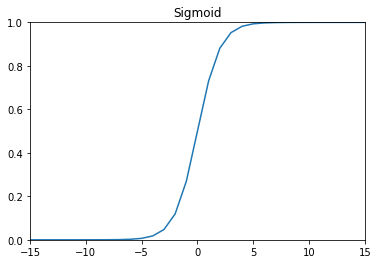

In [ ]:
#@title

k = 15

x = np.array(list(range(-k, k + 1)))
y = 1 / (1 + np.e ** (-x))

plt.plot(x, y)
plt.xlim(-k, k)
plt.ylim(0, 1)
plt.title('Sigmoid')
plt.show()

That is, sigmoid is an activation function that can map any real number into the $[0, 1]$ range, thus effectively converting it into a probability.

In order to apply BCE, we need to apply a sigmoid function to the output of the last layer. The resulting value, now a probability, will be the input to our loss function.

Let's get back to coding.

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self, n_features: int, n_hidden: int):
        super().__init__()
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, 1)
        # the loss_fn has now become the BCELoss
        self.loss_fn = torch.nn.BCELoss()

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        # actual forward
        out = self.lin1(x)
        out = torch.relu(out)
        out = self.lin2(out).squeeze(1)
        # we need to apply a sigmoid activation function
        out = torch.sigmoid(out)

        result = {'pred': out}

        # compute loss
        if y is not None:
            loss = self.loss(out, y)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)


In [ ]:
model = Classifier(len(marker2idx), 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.0)

# (y > 2.5).float()
# we convert y into boolean values
# this is required to support the formulation we are considering in this section
# (if it's greater than 2.5, then we are dealing with a positive review, otherwise it's negative)
# BCE expects a probability as its gold, which is mathematically represented by a float, hence the .float operation
training_loop(model, optimizer, adapt=lambda x, y : (x, (y > 2.5).float()))

In [ ]:
def predict(review: str):

    # we need to vectorize the review
    x = review2vector(review)

    # our nn expects a batched input
    # even if we have a single sample, we have to mock this structure converting a (11)-shape vector into (1, 11)-shape one
    batched_x = x.unsqueeze(0)

    # actual forward
    batch_out = model(batched_x)

    # return
    return batch_out['pred'][0].item()

def predict_and_print(review: str, stars: int):
    print(f'=' * 125)
    print(f'# review: {review}')
    print(f'# gold stars: {stars} -> {1 if stars > 2.5 else 0}')
    score = predict(review)
    print(f'# predicted score: {score} -> {round(score)}')
    print(f'=' * 125)


# 4 star review
predict_and_print('very good product. excellent quality', 4)

# 1 star review
predict_and_print('It echoes so badly with my voice. Don\'t waste your time. I\'m heavily considering returning it.', 1)

# review: very good product. excellent quality
# gold stars: 4 -> 1
# predicted score: 0.9999980926513672 -> 1
# review: It echoes so badly with my voice. Don't waste your time. I'm heavily considering returning it.
# gold stars: 1 -> 0
# predicted score: 0.004514429718255997 -> 0


In [ ]:
n = 0
d = 0

for x, y in test_dataloader:

    y = y > 2.5
        
    with torch.no_grad():
        batch_out = model(x)
        pred = batch_out['pred']

    pred = torch.round(pred)
    d += pred.shape[0]
    n += (y == pred).int().sum()

print(f'# accuracy: {(n / d).item():.2f}')

# accuracy: 1.00


Wow!

# Categorical Cross-Entropy

**Problem**: given a review $r$, determine the number of stars $y \in C = \{1, 2, 3, 4, 5\}$ it was originally assigned.

While it may seem quite similar to the regressive formulation we did with MSE, this formulation actually involves a **classification task**; in particular, as $|C| > 2$, this is a **multi-class classification task** (or multi-label classification task). Given an input, starting from a set $C$ of output values, we should the determine the correct one.

BCE here cannot be applied as it assumes that only $2$ values are being considered. Rather, its generalization to multi-class classification, **Categorical Cross-Entropy Loss** (often simply called Cross-Entropy Loss), is what is used:

\\[ \mathcal{L}_{CCE} = - \frac{1}{|y|} \sum_{i=1}^{|y|} \sum_{j=1}^{|C|} y_{i,j} log(p(y_{i, j})) \\]

Similarly to BCE, Cross-Entropy also works with probabilities. However, differently from BCE, rather than a single $p(y_i)$, Cross-Entropy expects a distribution over $C$, that is, a list of probabilities, one for each class $c$, that sums up to $1$. Visually:

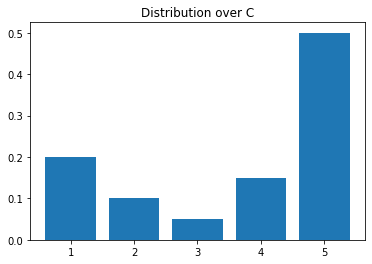

In [ ]:
#@title

x = [1, 2, 3, 4, 5]
y = [0.2, 0.1, 0.05, 0.15, 0.5]
assert sum(y) == 1.0

plt.bar(x, y)
plt.title('Distribution over C')
plt.show()

This is a bit more complex than what BCE requires and, most importantly, how can we make the NN emit it? Once more, it is quite straightforward. 

First, while up to this point the output shape of the final layer has always been $1$, we now change it to $|C|$; we can interpret the $j$-th value, which we denote with $z_j$, as the **score** the NN gives to class $C_j$. Then, we can convert these values into a probability distribution with a new activation function, the **softmax**:

\\[ Softmax(z_{i, j}) = \frac{e^{z_{i, j}}}{ \sum_{j'=1}^{|y|} e^{z_{i, j'}} } \\]

Thus:

\\[ p(y_{i, j}) = Softmax(z_{i, j}) \\]

The scores $z_0, \dots, z_{|C|}$ are often referred to as the **logits** of the softmax function.

In [ ]:
class Classifier(torch.nn.Module):

    def __init__(self, n_features: int, n_hidden: int):
        super().__init__()
        self.lin1 = torch.nn.Linear(n_features, n_hidden)
        # we have to emit logits over the values of C
        # As |C|=5, the output dimension of the last layer should be $5$ as well
        self.lin2 = torch.nn.Linear(n_hidden, 5)
        # this time, CrossEntropyLoss
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, x: torch.Tensor, y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        # actual forward
        out = self.lin1(x)
        out = torch.relu(out)
        out = self.lin2(out).squeeze(1)

        # compute logits (which are simply the out variable) and the actual probability distribution (pred, as it is the predicted distribution)
        logits = out
        pred = torch.softmax(out, dim=-1)

        result = {'logits': logits, 'pred': pred}

        # compute loss
        if y is not None:
            # while mathematically the CrossEntropyLoss takes as input the probability distributions,
            # torch optimizes its computation internally and takes as input the logits instead
            loss = self.loss(logits, y)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

In [ ]:
model = Classifier(len(marker2idx), 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.0)

# (y - 1).long()
# from an implementation point of view, PyTorch Softmax expects a list of classes that start 0
# as our classes start instead at 1, we need to offset them by -1
# Softmax also expects a LongTensor, hence the .long() operation
training_loop(model, optimizer, adapt=lambda x, y : (x, (y - 1).long()))

In [ ]:
def predict(review: str):

    # we need to vectorize the review
    x = review2vector(review)

    # our nn expects a batched input
    # even if we have a single sample, we have to mock this structure converting a (11)-shape vector into (1, 11)-shape one
    batched_x = x.unsqueeze(0)

    # actual forward
    batch_out = model(batched_x)

    # here it gets a bit tricky, let's extract the predicted probability distribution
    pred = batch_out['pred']

    # first of all, since we are mocking the batching behavior, let's just take the first
    pred = pred[0]

    # now, pred stores a probability distribution, assigning a probability p to each possible number of stars
    # in order to extract the "actual prediction", we can simply select the one with the highest probability
    pred = pred.argmax()

    # let's sum 1 as usual and, finally, return
    return pred.item() + 1

def predict_and_print(review: str, stars: int):
    print(f'=' * 125)
    print(f'# review: {review}')
    print(f'# gold stars: {stars}')
    score = predict(review)
    print(f'# predicted score: {score} -> {round(score)}')
    print(f'=' * 125)


# 4 star review
predict_and_print('very good product. excellent quality', 4)

# 1 star review
predict_and_print('It echoes so badly with my voice. Don\'t waste your time. I\'m heavily considering returning it.', 1)

# review: very good product. excellent quality
# gold stars: 4
# predicted score: 5 -> 5
# review: It echoes so badly with my voice. Don't waste your time. I'm heavily considering returning it.
# gold stars: 1
# predicted score: 1 -> 1


In [ ]:
n = 0
d = 0

for x, y in test_dataloader:

    y = y - 1
        
    with torch.no_grad():
        batch_out = model(x)
        pred = batch_out['pred']

    pred = pred.argmax(-1)
    d += pred.shape[0]
    n += (y == pred).int().sum()

print(f'# accuracy: {(n / d).item():.2f}')

# accuracy: 0.92


It works once more!

# Wrap Up and General Rules of Thumb

* NN expects numerical input $\rightarrow$ convert your data into numbers through some function $\phi$ ($\phi$ might be the identity function when dealing with some simple cases such as approximating the XOR function)
* Regression Task $\rightarrow$ use MSELoss
* Binary Classification Task $\rightarrow$ put a Sigmoid after your final Linear layer and use BCELoss
* Multi-Class Classification Task $\rightarrow$ set the output shape of your final layer to $|C|$, put a Softmax after it and use CrossEntropyLoss

# Homeworks

1. Try changing the considered markers and the function $\phi$
2. Choose one of the $3$ variants and try to re-implement everything with a slightly different architecture (use $3$ layers rather than $2$ for instance)